# General settings and loading of files

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp

from IPython.display import display, Math, Latex
from matplotlib import cm

% matplotlib inline
% load_ext autoreload
% autoreload 2

pd.options.display.max_columns = 40  # Affy csv has 30 fields
pd.options.display.mpl_style = 'default'

mpl.rc('figure', figsize=(13, 7))
mpl.rc('axes', titlesize=17, labelsize=14)
mpl.rc('xtick', labelsize=11)
mpl.rc('ytick', labelsize=11)
mpl.rc('font', family='serif')
mpl.rc('legend', fontsize=15)

In [3]:
%run helpers/data_munging_functions.py
%run helpers/number_helpers.py

In [4]:
%run discriminate_present_vs_missing.py

GALANTER_CSV = '~/tesina/galanter_SNPs.csv'
LAT1_CSV = '~/tesina/affy-LAT1/Axiom_GW_LAT.na35.annot.csv'  # 1.1Gb file!
# Smaller file for testing:
# LAT1_CSV_SMALL = "affy-LAT1/Axiom_GW_LAT.na35.annot.TRUNCATED.csv"

galanter, present, missing = discriminate_present_vs_missing(
    GALANTER_CSV, LAT1_CSV, dumpdir="dumpfiles")

In [5]:
% run discriminate_present_vs_missing.py

lat = _create_Affymetrix_df(LAT1_CSV)

In [6]:
affylat = lat[['Chromosome', 'Physical Position', 'Position End']]

In [7]:
affylat[affylat['Physical Position'] != affylat['Position End']].count()

Chromosome           1818
Physical Position    1818
Position End         1818
dtype: int64

In [8]:
affylat.count()

Chromosome           818154
Physical Position    818154
Position End         818154
dtype: int64

In [9]:
affylat.to_csv('affy-LAT1-SNPs.csv')

In [10]:
!head 'affy-LAT1-SNPs.csv'

dbSNP RS ID,Chromosome,Physical Position,Position End
rs1983864,10,100017453,100017453
rs746257,10,100021983,100021983
rs7899882,10,100030768,100030768
rs10786408,10,100031394,100031394
rs12221268,10,100087104,100087104
rs11189558,10,100102403,100102403
rs12258123,10,100136560,100136560
rs7098680,10,100152358,100152358
rs6584193,10,100155898,100155898


In [11]:
print("{} Galanter AIMs".format(len(galanter)))
print("{} present in LAT".format(len(present)))
print("{} missing in LAT".format(len(missing)))

446 Galanter AIMs
180 present in LAT
266 missing in LAT


In [12]:
# Temporary. I'd better look for the numbers of the last build of the HG

HUMAN_GENOME = '/home/juan/tesina/human_genome.txt'  # Chromosome lenghts and centromeres
genome = pd.read_csv(HUMAN_GENOME, delimiter="\t")
centromere_info = genome['centromere'].apply(lambda e: pd.Series(e.split(',')).astype(int))
genome = genome.drop('centromere', axis=1)
genome = pd.concat([genome, centromere_info], axis=1)
genome = genome.set_index('ID')
genome.columns = ['length', 'centromere_start', 'centromere_end']
genome = genome.drop(['X', 'Y'])
genome.index = genome.index.rename('chr')
genome.index = genome.index.astype(int)  # This only works after removing X and Y

### Distancias entre los AIMs por cromosoma

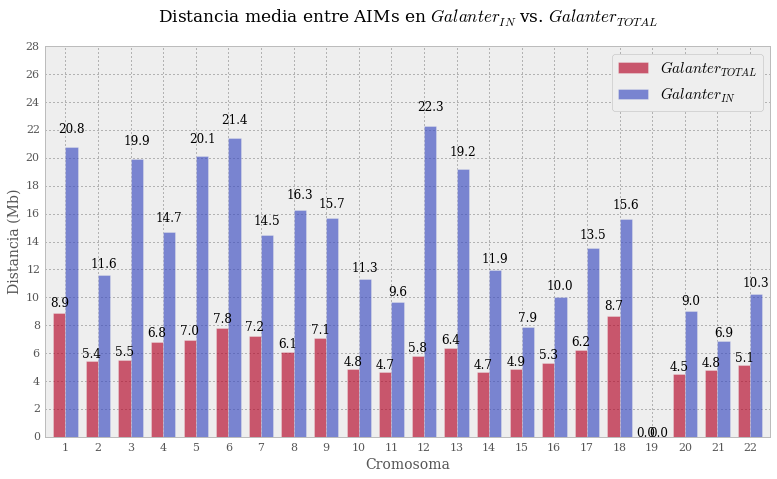

In [13]:
% run SNP_distances_plots.py

galanter_vs_present_mean_distance_plot(galanter, present, genome)
plt.show()

#### Discusión

* Las distancias medias son mucho mayores en $Galanter_{LAT}$ que en $Galanter_{all}$. En casos extremos, llega a más de 20 Mpb promedio entre AIMs, cuando esas distancias promedio no superan los 8 Mpb en el panel original.

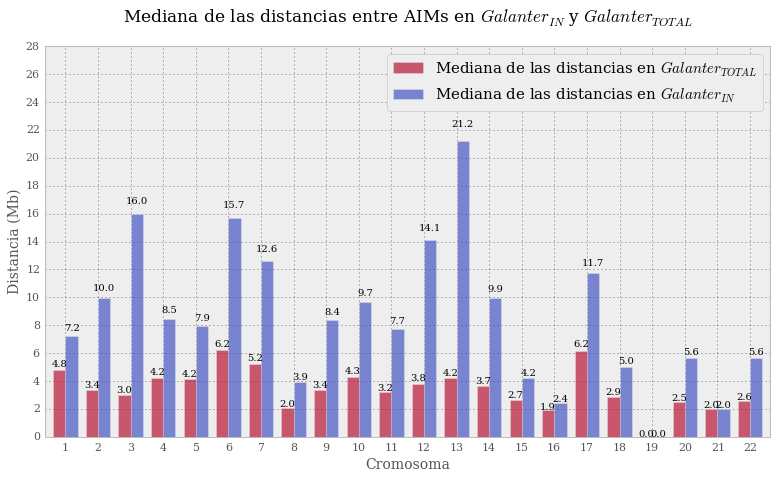

In [14]:
% run data_munging/distances.py

galanter_vs_present_median_distance_plot(galanter, present, genome)
plt.show()

### Discusión

__Nota__: hay un solo AIM en Galanter para el cromosoma 19, de modo que no se grafican distancias.

* En algunos casos extremos, hay hasta 1.4 Mpb (cromosoma 1) y 1 Mpb (cromosoma 8) de distancia entre dos AIMs contiguos.

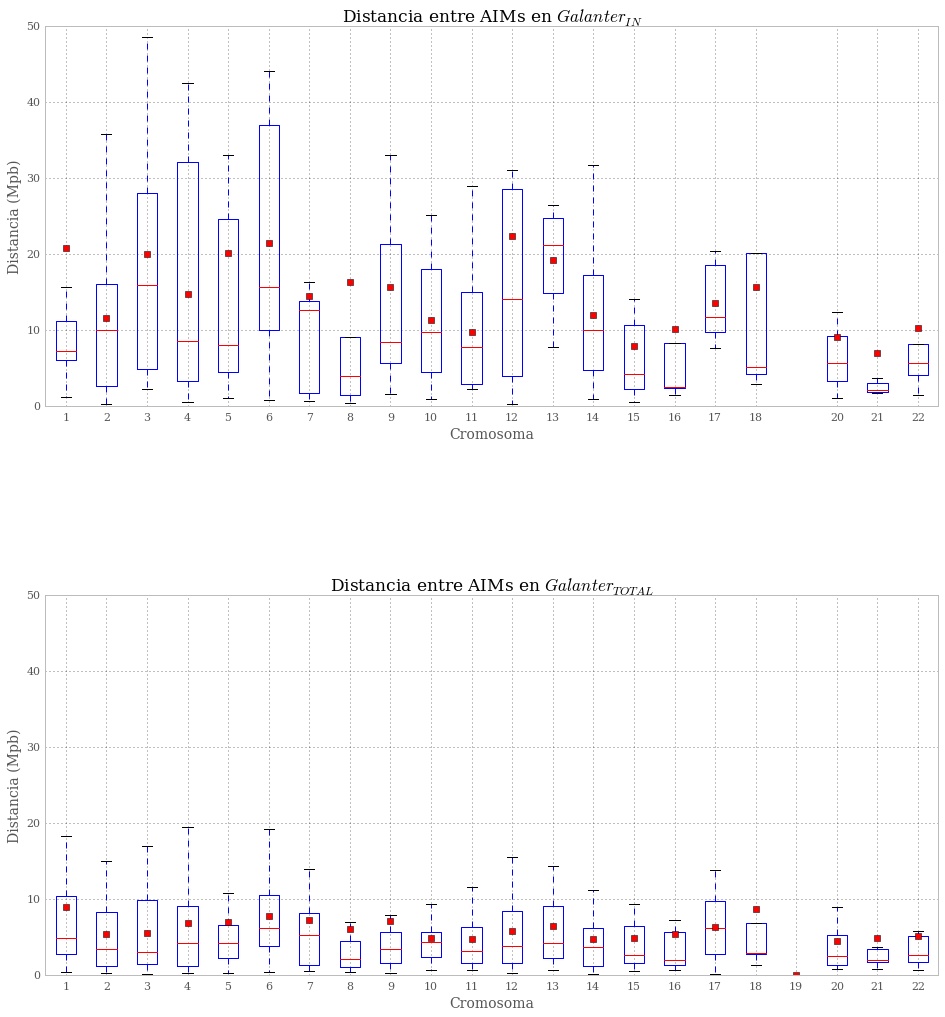

In [15]:
% run data_munging/distances.py

ax1 = plt.subplot(211)
ax1 = distances_boxplot(present, genome, ax=ax1, showfliers=False, showmeans=True,
                        title=r"Distancia entre AIMs en $Galanter_{IN}$")

ax2 = plt.subplot(212, sharey=ax1)
ax2 = distances_boxplot(galanter, genome, ax=ax2, showfliers=False, showmeans=True,
                        title=r"Distancia entre AIMs en $Galanter_{TOTAL}$")

f = ax2.figure
f.set_figheight(17)
f.set_figwidth(16)

plt.show()

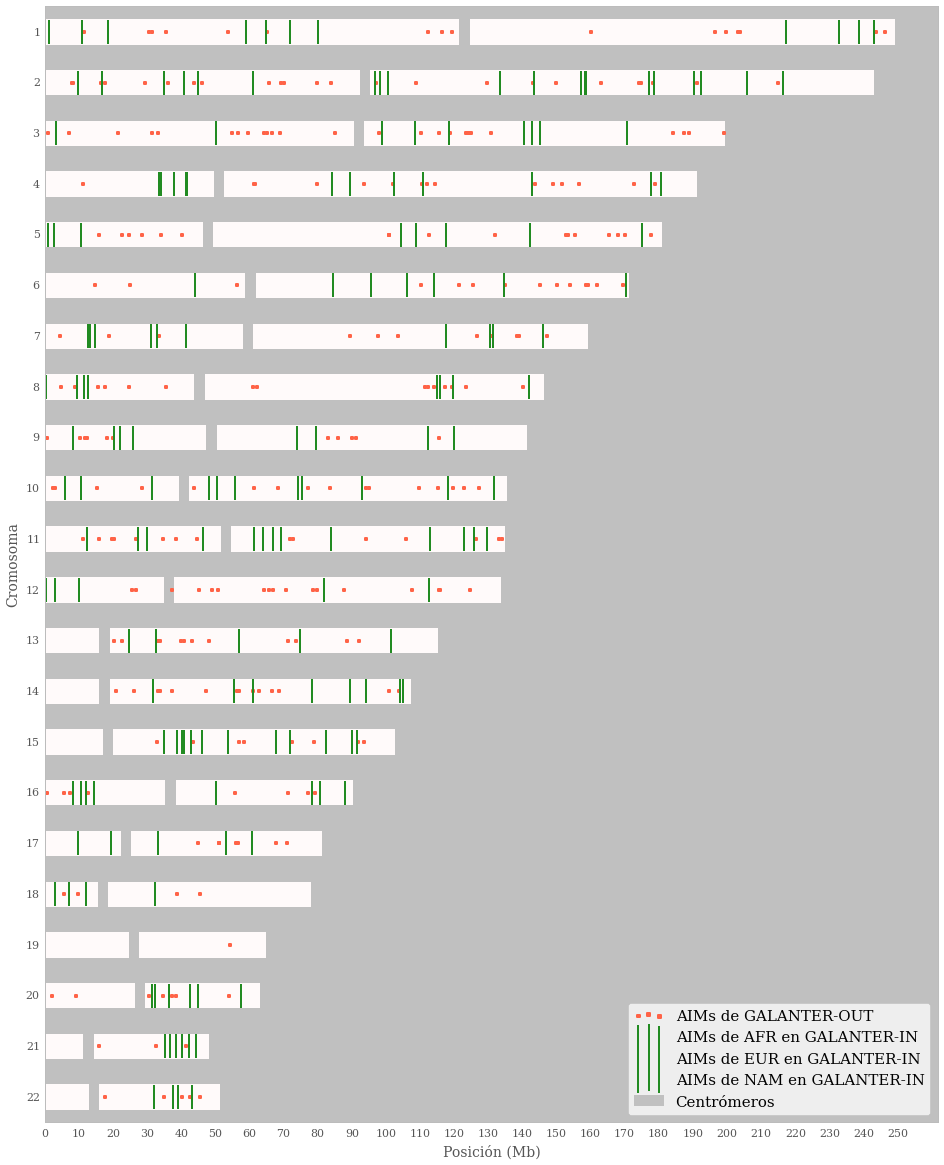

In [16]:
% run chromosomes_with_SNPs_plot.py

from collections import OrderedDict


plot_data = OrderedDict([
    ('AIMs de GALANTER-OUT',
     {'df': missing, 'marker': 's', 's': 7, 'color': 'tomato'}),
        
    ('AIMs de AFR en GALANTER-IN',
     {'df': present[present.population == "AFR"],
      'marker': '|', 'color': 'forestGreen', 's': 600}),
        
    ('AIMs de EUR en GALANTER-IN',
     {'df': present[present.population == "EUR"],
      'marker': '|', 'color': 'forestGreen', 's': 600}),
        
    ('AIMs de NAM en GALANTER-IN',
     {'df': present[present.population == "NAM"],
      'marker': '|', 'color': 'forestGreen', 's': 600}),
])

chromosomes_with_SNPs_plot(genome, plot_data)
plt.show()

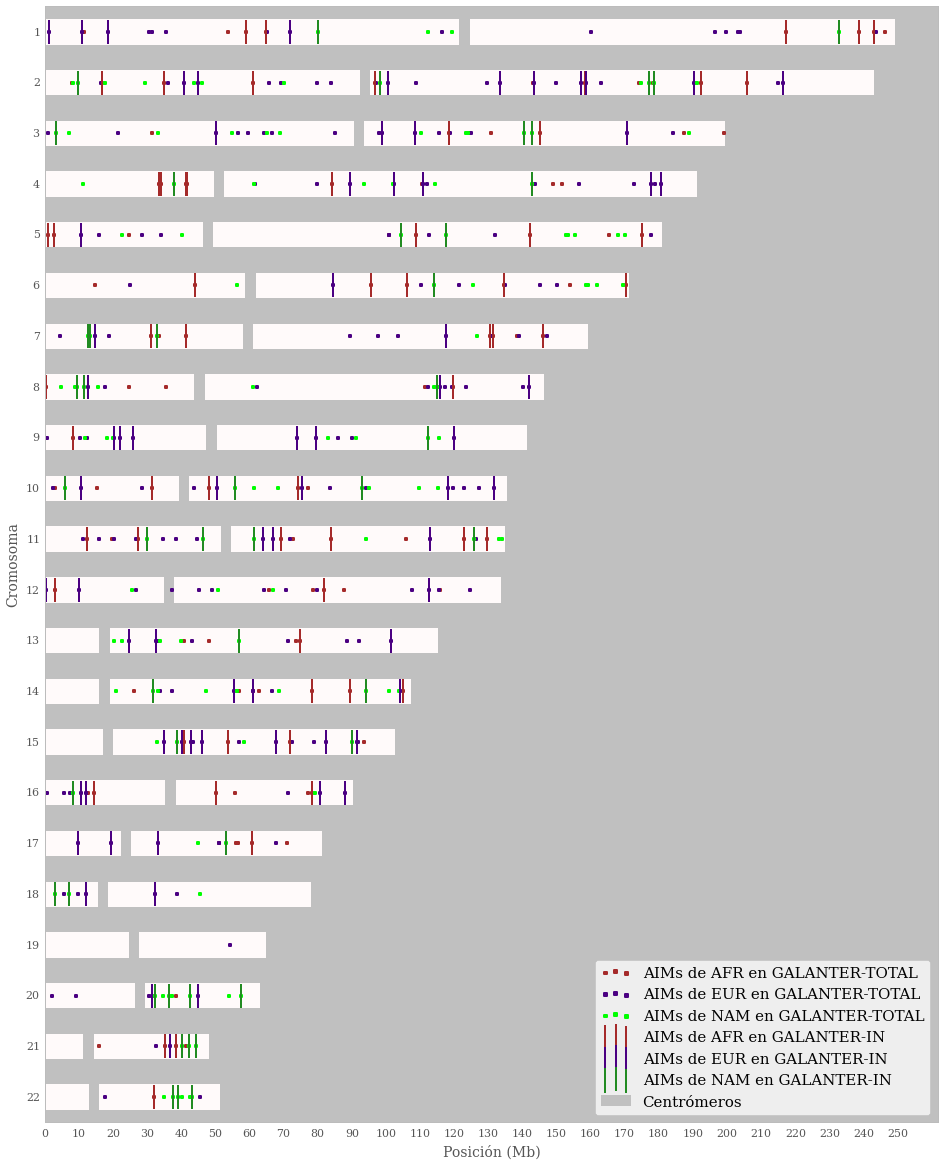

In [17]:
% run chromosomes_with_SNPs_plot.py

from collections import OrderedDict


plot_data = OrderedDict([
        
    ('AIMs de AFR en GALANTER-TOTAL',
     {'df': galanter[galanter.population == "AFR"],
      'marker': 's', 'color': 'brown', 's': 7}),
        
    ('AIMs de EUR en GALANTER-TOTAL',
     {'df': galanter[galanter.population == "EUR"],
      'marker': 's', 'color': 'indigo', 's': 7}),
        
    ('AIMs de NAM en GALANTER-TOTAL',
     {'df': galanter[galanter.population == "NAM"],
      'marker': 's', 'color': 'lime', 's': 7}),
        
    ('AIMs de AFR en GALANTER-IN',
     {'df': present[present.population == "AFR"],
      'marker': '|', 'color': 'brown', 's': 600}),
        
    ('AIMs de EUR en GALANTER-IN',
     {'df': present[present.population == "EUR"],
      'marker': '|', 'color': 'indigo', 's': 600}),
        
    ('AIMs de NAM en GALANTER-IN',
     {'df': present[present.population == "NAM"],
      'marker': '|', 'color': 'forestGreen', 's': 600}),
])

chromosomes_with_SNPs_plot(genome, plot_data)
plt.show()

In [18]:
def pop_counts(df):
    return df.groupby(['chr', 'population']).size().unstack().fillna('>> 0 <<')

df = pd.merge(pop_counts(galanter), pop_counts(present),
         left_index=True, right_index=True,
         suffixes=['_TOTAL', '_IN'])

df.columns = pd.MultiIndex.from_product([['$GALANTER_{TOTAL}$', '$GALANTER_{IN}$'],
                                         ['AFR', 'EUR', 'NAM']])
df

$GALANTER_{TOTAL}$         $GALANTER_{IN}$                  
                   AFR EUR NAM             AFR      EUR      NAM
chr                                                             
1                    8  15   4               5        4        2
2                   11  21  12               7        9        4
3                    7  16  12               2        4        3
4                    8  12   7               5        5        2
5                    8   8   9               5        1        2
6                    7   7   7               5        1        1
7                    7  10   4               5        2        3
8                    5  10   8               2        3        3
9                    1  11   7               1        6        1
10                   6  13   8               3        5        3
11                   9  12   7               6        3        4
12                   6  13   3               2        3  >> 0 <<
13                   4   8   5               1        3        1
14                   7   6   9               3        3        2
15                   4  12   4               3        7        2
16                   6   8   2               3        4        1
17                   5   5   2               1        3        1
18             >> 0 <<   5   3         >> 0 <<        2        2
20                   1   5   7         >> 0 <<        2        4
21                   4   2   3               2        1        3
22                   1   2   6               1  >> 0 <<        3

**DISCUSIÓN**

La reducción de AIMs en GALANTER-IN determina que ciertos cromosomas no tengan ningún AIM de una población determinada:

- En el cromosoma 12 se perdieron los 3 AIMs de NAM.
- En el cromosoma 20 se perdió el único AIM de AFR.
- En el cromosoma 22 se perdieron los 2 AIMs de EUR.

## Diferenciar por población de referencia, present vs galanter

     $Galanter_{IN}$  $Galanter_{TOTAL}$
AFR         0.344444            0.257848
EUR         0.394444            0.452915
NAM         0.261111            0.289238
     $Galanter_{IN}$  $Galanter_{OUT}$
AFR               53                62
EUR              131                71
NAM               82                47


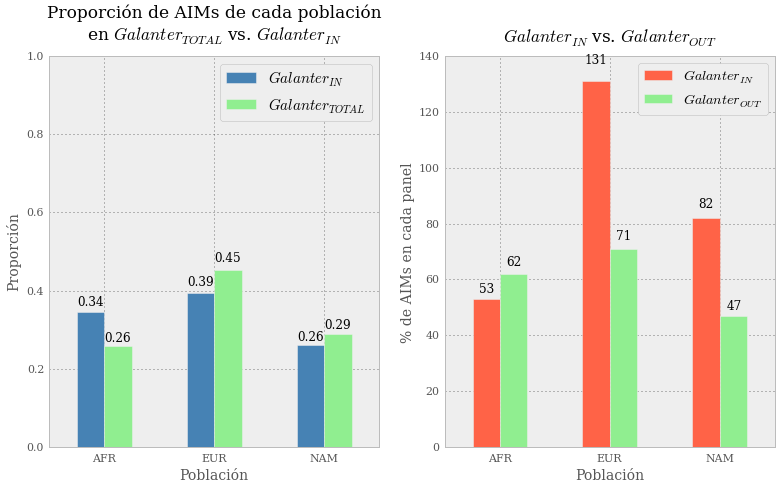

In [19]:
% run superpopulation_ratios_plot.py

superpopulation_ratios_plot(galanter, present)
superpopulation_count_plot(present, missing)

plt.show()

# Comparar Galanter con la data de 1000Genomes

In [20]:
# %load /home/juan/tesina/1000genomes/ftp_download_1000_genomes.py

In [21]:
# % run extract_SNPs_from_vcf_chromosomes.py

# commands = extract_SNPs_from_vcf(galanter.index.values)

# ^ One time only run, to extract the SNPs out of the big files of 1000genomes:
# run_commands(commands, "/home/juan/tesina/1000genomes")

In [22]:
%run read_samples_data.py

sample_populations_file = "/home/juan/tesina/1000genomes/integrated_call_samples_v3.20130502.ALL.panel"
sample_populations = read_samples_data(sample_populations_file)

In [23]:
%run read_1000genomes_data.py
%run helpers/data_munging_functions.py

import itertools
from glob import glob
from os.path import isfile


vcf_filenames = glob("/home/juan/tesina/1000genomes/chr_*recode*")
df_1000genomes_dumpfile = "dumpfiles/galanter_in_1000G.csv"
samples_genotypes_dumpfile = "dumpfiles/1000G_sample_genotypes.csv"

if not isfile(df_1000genomes_dumpfile):
    records = [_vcf_records(vcf_filename) for vcf_filename in vcf_filenames]
    records = itertools.chain.from_iterable(records)  # Flattens list of lists
    records_as_dictionaries = [_vcf_record_to_dict(r) for r in records]

    # Clean up 1000genomes data
    df_1000genomes = pd.DataFrame(records_as_dictionaries).set_index('ID')
    df_1000genomes = df_1000genomes.dropna(axis=1)
    df_1000genomes = df_1000genomes.drop(['FILTER', 'alleles'], axis=1)
    df_1000genomes = remove_unkown_snp_subtypes(df_1000genomes)
    df_1000genomes = remove_unnecessary_lists_from_df(df_1000genomes)

    # Get sample genotypes
    frames = [pd.DataFrame(dict(genotypes), index=[rs])
              for rs, genotypes in df_1000genomes['sample_genotypes'].iteritems()]
    sample_genotypes = pd.concat(frames).transpose()
    sample_genotypes.to_csv(samples_dumpfile)

    # Remove big unnecessary field after exporting its data to 'samples_genotypes'
    df_1000genomes = df_1000genomes.drop('sample_genotypes', axis=1)
    df_1000genomes.to_csv(df_1000genomes_dumpfile)

df_1000genomes = pd.read_csv(df_1000genomes_dumpfile, index_col='ID')
sample_genotypes = pd.read_csv(samples_genotypes_dumpfile, index_col=0)

In [24]:
population_MAF_dumpfile = "dumpfiles/galanter_MAF_per_population.csv"

if not isfile(population_MAF_dumpfile):
    freq_by_population = defaultdict(dict)

    for rs, genotypes in sample_genotypes.filter(regex='rs').iteritems():
        alt_alleles_count = defaultdict(lambda: 0)
        total_alleles_count = defaultdict(lambda: 0)

        for sample, genotype in genotypes.iteritems():
            population = samples_genotypes.loc[sample].population
            super_population = samples_genotypes.loc[sample].super_population
            alt_alleles_count[population] += genotype
            alt_alleles_count[super_population] += genotype
            total_alleles_count[population] += 2
            total_alleles_count[super_population] += 2

        for population, alt_alleles in alt_alleles_count.items():
            freq_by_population[rs][population] = alt_alleles / total_alleles_count[population]

    freqs = pd.DataFrame(dict(freq_by_population)).transpose()
    mafs = freqs.applymap(lambda freq: min(freq, 1 - freq))
    mafs.to_csv(population_MAF_dumpfile)

maf_by_population = pd.read_csv(population_MAF_dumpfile, index_col=0)

In [25]:
%run population_names.py

dumpfile = "dumpfiles/population_names.csv"
population_names = create_population_names_df(dumpfile)

In [26]:
def whois(pop_code):
    return population_names.loc[pop_code]['Population Description']

whois('ACB')

'African Caribbeans in Barbados'

### Comparar SNPs

In [27]:
print("1000 Genomas:", len(df_1000genomes))
print("Galanter panel:", len(galanter))

1000 Genomas: 442
Galanter panel: 446


**NOTA** sobre los 4 SNPs que faltan
- un SNP tiene mal el cromosoma en Galanter
- en el proceso de leer la data de 1000 genomas estoy dejando afuera tres SNPs, porque tienen más de 2 variantes.

In [28]:
missing_in_1000g = set(galanter.index) - set(df_1000genomes.index)
galanter.loc[missing_in_1000g]

,chr,position,A1,A2,NAM_AF,EUR_AF,AFR_AF,population,LSBL(Fst),LSBL(In)
SNP rsID,,,,,,,,,,
rs2242865,21,15948902,G,T,0.011,0.156,0.932,AFR,0.695,0.422
rs2510719,11,126511001,A,C,0.034,0.574,0.039,EUR,0.341,0.196
rs12065716,1,116575568,G,C,0.389,0.885,0.136,EUR,0.372,0.207
rs10071261,5,1066694,T,C,0.107,0.086,0.903,AFR,0.650,0.375


### Ver qué subpoblaciones se van en $Galanter_{IN}$ y cuáles quedan

/usr/local/lib/python3.4/dist-packages/pandas/tools/plotting.py:2633: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  warnings.warn(msg, FutureWarning)


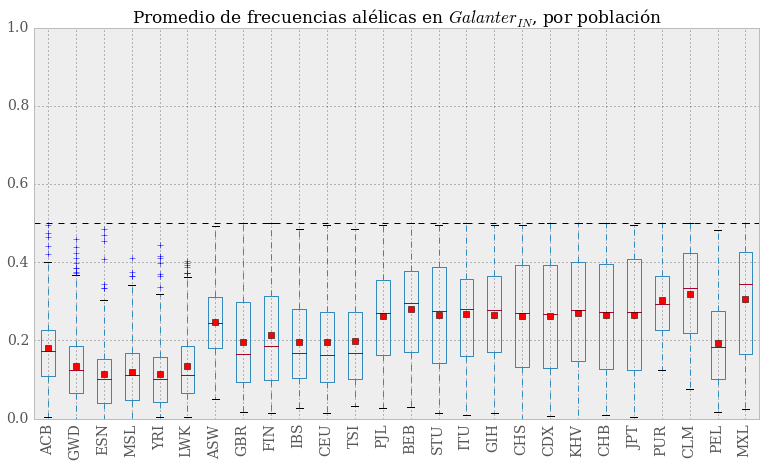

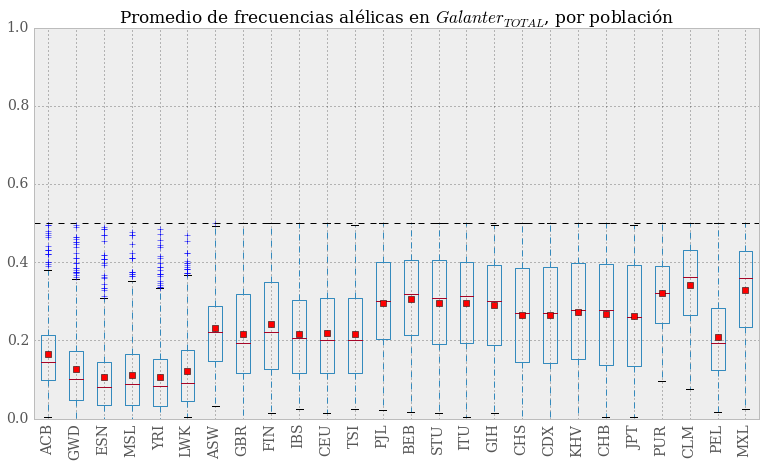

In [29]:
% run analyze_populations_in_galanter.py

populations_to_plot = []

for superpop in ['AFR', 'EUR', 'SAS', 'EAS', 'AMR']:
    pops = sample_populations[sample_populations.super_population == superpop].population.unique()
    populations_to_plot += list(pops)

dfs = {'$Galanter_{IN}$': present,
       '$Galanter_{TOTAL}$': galanter}

for name, df in dfs.items():
    df = df.join(maf_by_population).filter(regex='|'.join(populations_to_plot))
    df = df[populations_to_plot]
    
    ax = boxplot_freqs_by_populations(
        df, populations_to_plot,
        title="Promedio de frecuencias alélicas en {}, por población".format(name),
    )
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.show()

/usr/local/lib/python3.4/dist-packages/pandas/tools/plotting.py:2633: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  warnings.warn(msg, FutureWarning)


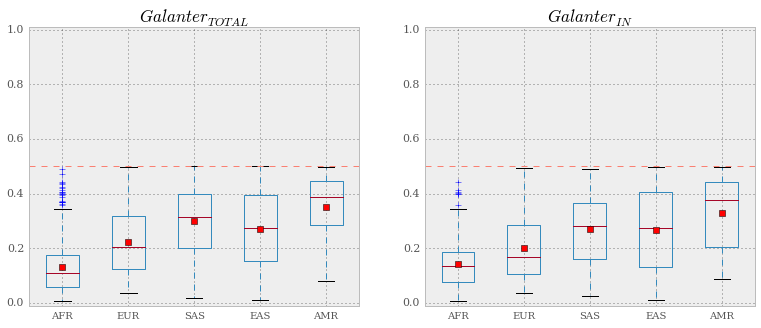

In [30]:
fig, axes = plt.subplots(1, 2, sharey=False)
titles = ("$Galanter_{TOTAL}$", "$Galanter_{IN}$" )

for i, df in enumerate([galanter, present]):
    ax = axes[i]
    df = df.join(maf_by_population).filter(['AFR', 'EUR', 'SAS', 'EAS', 'AMR'])
    df.boxplot(ax=ax, rot=0, showmeans=True)
    ax = axes[i]
    ax.set_title(titles[i])
    ax.set_ylim([-0.01, 1.01])
    ax.axhline(0.5, color='salmon', linestyle='--')

fig.set_figheight(5)
plt.show()

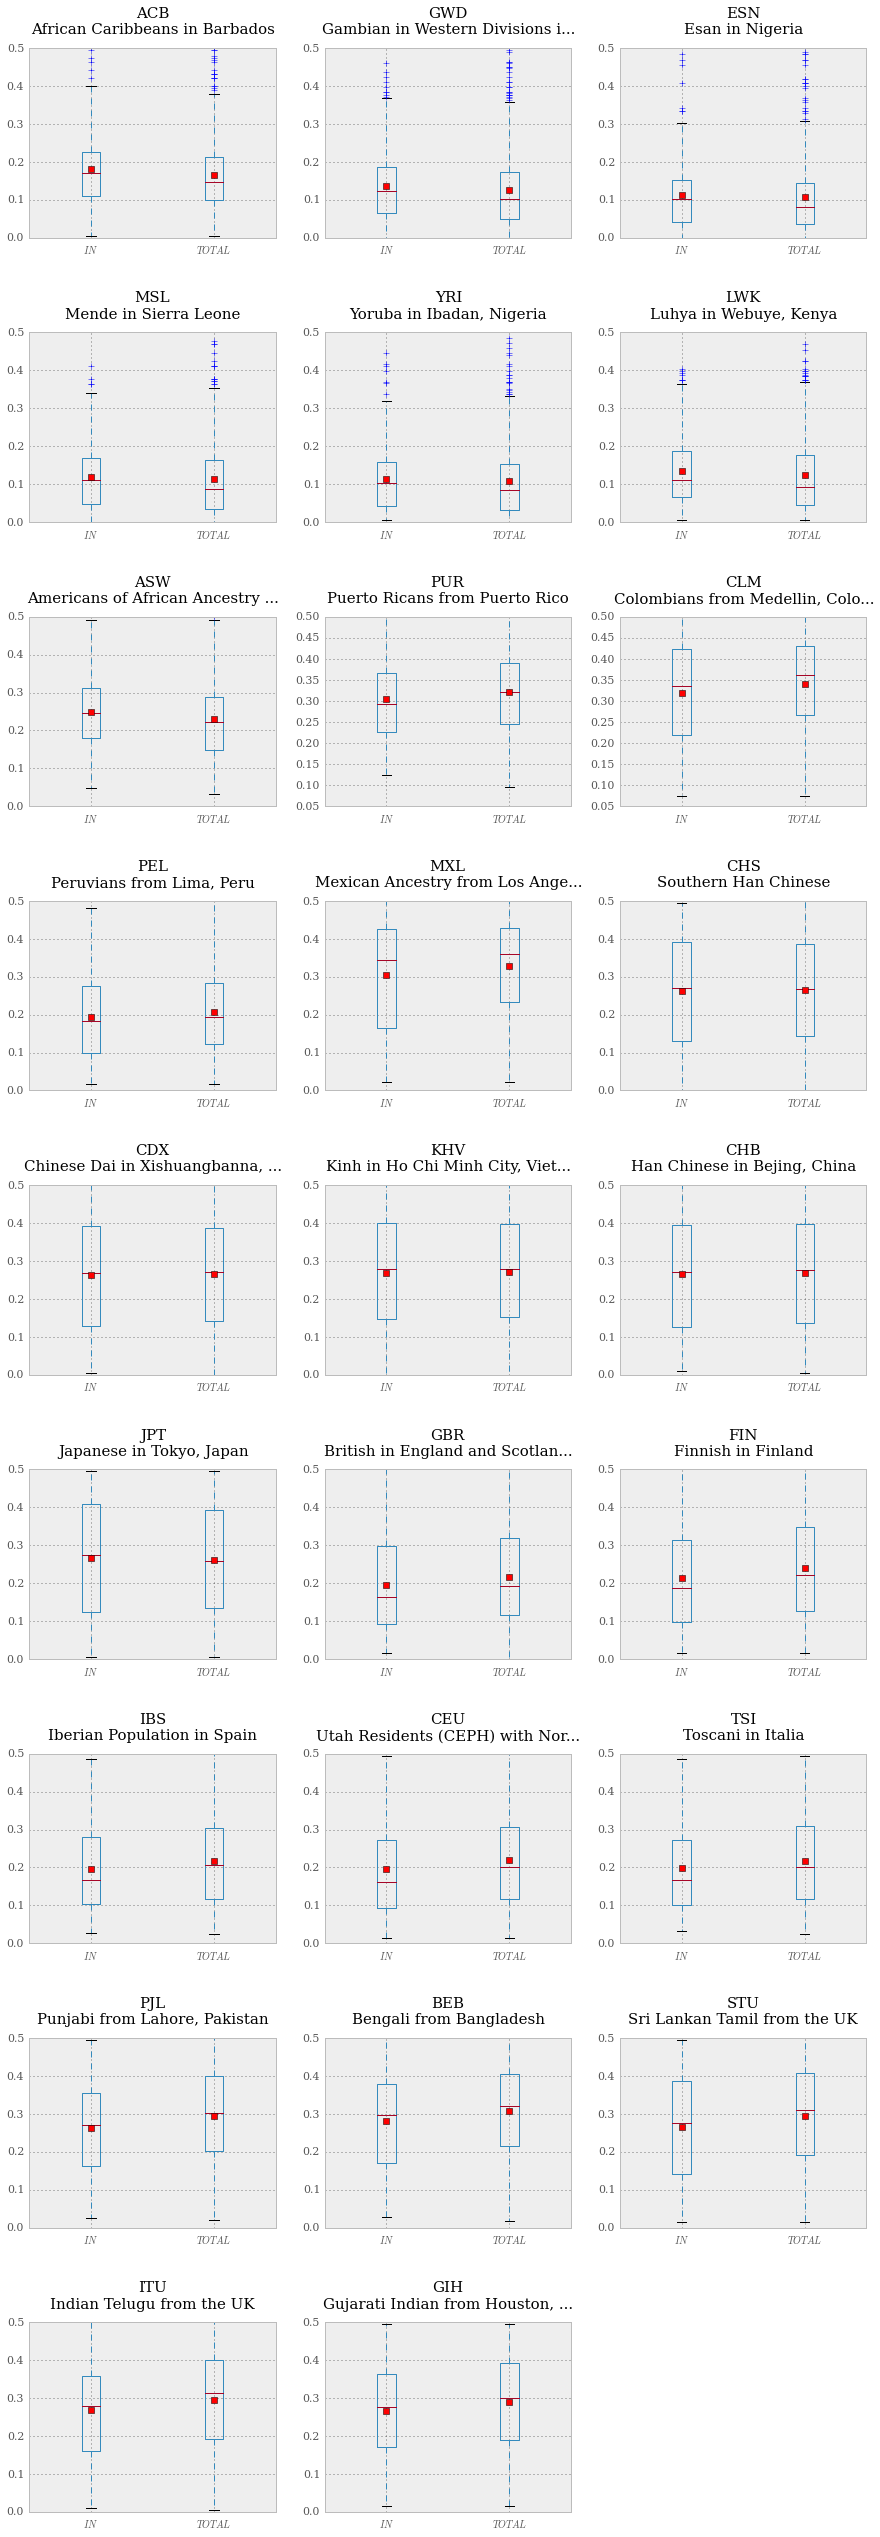

In [31]:
% run helpers/text_helpers.py

populations_to_plot = [p for p in sample_populations.sort('super_population')['population'].unique()]

get_freqs = lambda df: df.join(maf_by_population)[populations_to_plot]

chart_width = 5
chart_height = 5
fig_rows = 18
fig_cols = 3

fig = plt.figure(figsize=(fig_cols * chart_height, fig_rows * chart_width))

for i, population in enumerate(populations_to_plot):
    df = pd.DataFrame({'$IN$': get_freqs(present)[population],
                       '$TOTAL$': get_freqs(galanter)[population]})

    ax = plt.subplot(fig_rows, fig_cols, i+1)
    pop_description = population_names.loc[population]['Population Description']
    ax.set_title(population + "\n" + trunc_text(pop_description, 30), y=1.05, fontsize=15)    
    df.boxplot(ax=ax, showmeans=True, return_type='both')

plt.show()

In [32]:
mean_frequencies = lambda df: maf_by_population.loc[df.index].mean()
std_frequencies = lambda df: maf_by_population.loc[df.index].std()

In [33]:
from collections import OrderedDict

pd.DataFrame(OrderedDict([
    ('$Galanter_{TOTAL}$ mean', mean_frequencies(present)),
    ('$Galanter_{IN}$ mean', mean_frequencies(galanter)),
    ('$Galanter_{TOTAL}$ std', std_frequencies(present)),
    ('$Galanter_{IN}$ std', std_frequencies(galanter))
]))

,$Galanter_{TOTAL}$ mean,$Galanter_{IN}$ mean,$Galanter_{TOTAL}$ std,$Galanter_{IN}$ std
ACB,0.181215,0.166478,0.096727,0.099459
AFR,0.143506,0.133561,0.088909,0.095077
AMR,0.329585,0.351960,0.130475,0.116058
ASW,0.248374,0.230806,0.099467,0.102059
BEB,0.281019,0.306403,0.128408,0.120951
CDX,0.262149,0.265570,0.146044,0.140788
CEU,0.195503,0.219194,0.123740,0.123281
CHB,0.264631,0.267759,0.148695,0.142275
CHS,0.262969,0.265255,0.146424,0.140407
CLM,0.318971,0.341220,0.121574,0.109731


In [34]:
import numpy as np
from collections import OrderedDict

df = pd.DataFrame(OrderedDict([
    ('$Galanter_{TOTAL}$', mean_frequencies(galanter)),
    ('$Galanter_{IN}$', mean_frequencies(present)),
    ('freq_diff', mean_frequencies(galanter) - mean_frequencies(present)),
])).sort('$Galanter_{TOTAL}$', ascending=False)

df = df.applymap(lambda n: round(n, 2))
freq_diff = df.join(population_names[['Population Description', 'Super Population Code']]).fillna('')
freq_diff

,$Galanter_{TOTAL}$,$Galanter_{IN}$,freq_diff,Population Description,Super Population Code
AMR,0.35,0.33,0.02,,
CLM,0.34,0.32,0.02,"Colombians from Medellin, Colombia",AMR
MXL,0.33,0.31,0.02,Mexican Ancestry from Los Angeles USA,AMR
PUR,0.32,0.30,0.02,Puerto Ricans from Puerto Rico,AMR
BEB,0.31,0.28,0.03,Bengali from Bangladesh,SAS
SAS,0.30,0.27,0.03,,
ITU,0.30,0.27,0.03,Indian Telugu from the UK,SAS
STU,0.30,0.27,0.03,Sri Lankan Tamil from the UK,SAS
PJL,0.29,0.26,0.03,"Punjabi from Lahore, Pakistan",SAS
GIH,0.29,0.27,0.03,"Gujarati Indian from Houston, Texas",SAS


### Comparar posiciones (Galanter las tiene desplazadas)

In [35]:
positions = galanter[['chr', 'position']].join(df_1000genomes[['CHROM', 'POS']])
positions.columns = ['chr_galanter', 'pos_galanter', 'chr_1000g', 'pos_1000g']
positions['pos_diff'] = positions['pos_galanter'] - positions['pos_1000g']
positions = positions.dropna(axis=0, how='any')
positions = positions.applymap(lambda n: int(n))
format_numbers(positions.head())

,chr_galanter,pos_galanter,chr_1000g,pos_1000g,pos_diff
SNP rsID,,,,,
rs6685064,1,"1,201,155",1,"1,211,292","-10,137"
rs12085319,1,"10,952,065",1,"11,029,478","-77,413"
rs2745285,1,"11,549,445",1,"11,626,858","-77,413"
rs4920310,1,"18,436,476",1,"18,563,889","-127,413"
rs6684063,1,"30,471,927",1,"30,699,340","-227,413"


### Comparación de la "heterocigosidad"

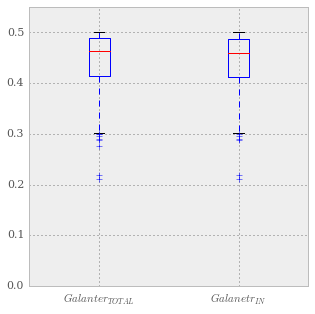

In [36]:
galanter_heter = galanter.join(df_1000genomes, rsuffix='_').heterozygosity
missing_heter = missing.join(df_1000genomes, rsuffix='_').heterozygosity

plt.figure(figsize=(5, 5))
ax = plt.subplot(111)
ax.boxplot([galanter_heter, missing_heter])
ax.set_xticklabels(['$Galanter_{TOTAL}$', '$Galanetr_{IN}$'])
ax.set_ylim([0, .55])
plt.show()

**DISCUSIÓN**

Los datos de 1000Genomes incluyen un valor de heterozigosidad. La distribución de esta métrica parece muy similar en ambos paneles.

## Dot plot de frecuencias por población

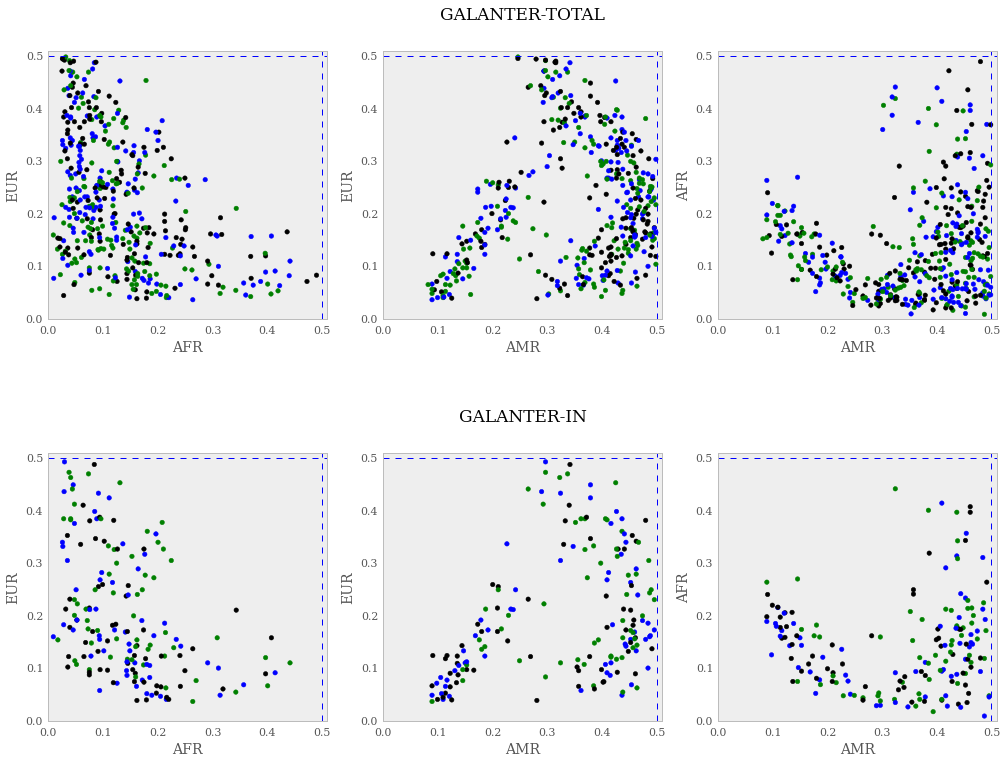

In [37]:
import itertools

height = 6

panels = {'GALANTER-TOTAL': galanter, 'GALANTER-IN': present}
populations = ['AMR', 'AFR', 'EUR']
colors = {'AFR': 'k', 'EUR': 'b', 'AMR': 'g'}
fig = plt.figure(figsize=(17, height * len(panels)))
axes = [plt.subplot(2, 3, n+1) for n in range(6)]

for panel_label, df in panels.items():
    df = df.join(maf_by_population)
    for pop1, pop2 in itertools.combinations(populations, 2):
        ax = axes.pop()
        ax.scatter(df[pop1], df[pop2], color=[colors[p] for p in populations])
        ax.set_ylim([0, .51])
        ax.set_xlim([0, .51])
        ax.set_xlabel(pop1)
        ax.set_ylabel(pop2)
        if len(axes) in [4, 1]:
            ax.set_title(panel_label, y=1.1)
        ax.grid()
        ax.axvline(0.5, linestyle='--')
        ax.axhline(0.5, linestyle='--')

**^ WIP, not yet finished. **

# Preparar datos para PCA, STRUCTURE, EIGEN...

## Crear PED, MAP, FAM files

In [38]:
from os.path import isfile

genotypes_dumpfile = "dumpfiles/genotypes_for_ped.csv"

if not isfile(genotypes_dumpfile):
    snp_alleles = df_1000genomes[['REF', 'ALT']]

    def genotype_to_allele(genotype, rs_ID, chrom_n, snp_alleles):
        # genotypes are {0: [REF, REF], 1: [REF, ALT], 2: [ALT, ALT]}
        ref, alt = snp_alleles.loc[rs_ID][['REF', 'ALT']]
        if genotype == 0:
            return (ref, ref)[chrom_n]
        elif genotype == 1:
            return (ref, alt)[chrom_n]
        elif genotype == 2:
            return (alt, alt)[chrom_n]

        raise ValueError("I don't know genotype '{}'".format(genotype))

    chrom_1_genotypes = pd.DataFrame(index=sample_genotypes.index)
    chrom_2_genotypes = chrom_1_genotypes.copy()

    for rs_ID, genotypes in sample_genotypes.transpose().iterrows():
        # print(list(sample_genotypes).index(rs_ID))
        chrom_1_genotypes[rs_ID + "_0"] = genotypes.apply(
            genotype_to_allele, args=(rs_ID, 0, snp_alleles))
        chrom_2_genotypes[rs_ID + "_1"] = genotypes.apply(
            genotype_to_allele, args=(rs_ID, 1, snp_alleles))

    genotypes = pd.concat([chrom_1_genotypes, chrom_2_genotypes], axis=1)
    genotypes = genotypes[sorted(genotypes.columns)]
    genotypes.to_csv(genotypes_dumpfile)

genotypes = pd.read_csv(genotypes_dumpfile, index_col=0)

In [39]:
map_filenames = ['files/present.map', 'files/galanter.map']
    
for df in [galanter, present]:
    map_filename = map_filenames.pop()
    map_df = df_1000genomes.loc[df.index].reset_index()
    map_df['MORGANS'] = 0  # MAP file must have this column, 0 is unknown
    map_df = map_df[['CHROM', 'SNP rsID', 'MORGANS', 'POS']].dropna()
    map_df['CHROM'] = map_df['CHROM'].astype(int)
    map_df['POS'] = map_df['POS'].astype(int)
    map_df.to_csv(map_filename, sep="\t", index=False, header=False)

cols = ['CHROM', 'SNP rsID', 'MORGANS', 'POS']
map_df_galanter = pd.read_csv('files/galanter.map', sep="\t", names=cols)
map_df_present = pd.read_csv('files/present.map', sep="\t", names=cols)

In [40]:
from os.path import isfile

pop_codes = dict(zip(population_names.index.values, range(len(population_names))))
ped_dumpfiles = ['files/galanter.ped', 'files/present.ped']
maps = [map_df_galanter, map_df_present]

for i, df in enumerate([galanter, present]):
    ped_dumpfile = ped_dumpfiles[i]

    if not isfile(ped_dumpfile):
        # Duplicate index for diploid
        index = sample_populations.sort(['population']).index
        ped = pd.DataFrame(index=index)

        ped['Family ID'] = 0
        # ped['Family ID'] = sample_populations.population.apply(lambda p: pop_codes.get(p, 0))
        ped['Individual ID'] = ped.index
        ped['Paternal ID'] = 0  # Should I look up 1000Genomes trios data?
        ped['Maternal ID'] = 0  # Should I look up 1000Genomes trios data?
        ped['Sex'] = sample_populations.gender.apply(lambda g: {'male': 1, 'female': 2}.get(g, 0))
        ped['Phenotype'] = 0

        for rs_ID in maps[i]['SNP rsID']:
            for rs_ID_chrom, series in genotypes.filter(regex=rs_ID).transpose().iterrows():
                ped[rs_ID_chrom] = series

        ped = ped.reset_index().drop('sample', axis=1)
        ped.to_csv(ped_dumpfile, sep="\t", index=False, header=False)

# ped_present, ped_galanter = [pd.read_csv(fn, sep="\t", columns=[]) for fn in ped_dumpfiles]

## Muestra de latinos, africanos, europeos

In [41]:
no_asians = sample_populations[sample_populations.super_population.isin(['EUR', 'AMR', 'AFR'])]
no_asians = no_asians.sort(['population'])
pd.DataFrame(no_asians.index).to_csv("files/no_asians/no_asians", header=False, index=False)

In [42]:
len(no_asians)

1511

In [43]:
just_latinos = sample_populations[sample_populations.super_population == 'AMR']
just_latinos = just_latinos.sort(['population'])
pd.DataFrame(just_latinos.index).to_csv("files/just_latinos/just_latinos", header=False, index=False)

In [44]:
len(just_latinos)

347

In [45]:
# latinos_with_ancestral = just_latinos
yorubas = sample_populations[sample_populations.population == 'YRI']
italians = sample_populations[sample_populations.population == 'TSI']
chinese = sample_populations[sample_populations.population == 'CHB']
latinos_with_ancestrals = pd.concat([yorubas, italians, chinese, just_latinos])
pd.DataFrame(latinos_with_ancestrals.index).to_csv(
    "files/latinos_with_ancestrals/latinos_with_ancestrals",
    header=False, index=False)

In [46]:
latinos_with_ancestrals.sort('population').population.values

array(['CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB',
       'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB',
       'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB',
       'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB',
       'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB',
       'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB',
       'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB',
       'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB',
       'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB',
       'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB',
       'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB', 'CHB',
       'CHB', 'CHB', 'CHB', 'CHB', 'CLM', 'CLM', 'CLM', 'CLM', 'CLM',
       'CLM', 'CLM', 'CLM', 'CLM', 'CLM', 'CLM', 'CLM', 'CLM', 'CLM',
       'CLM', 'CLM', 'CLM', 'CLM', 'CLM', 'CLM', 'CLM', 'CLM', 'CLM',
       'CLM', 'CLM',

# Leer resultados de ADMIXTURE

# Ver si HDGP tiene estos SNPs

In [47]:
hgdp_all = pd.read_csv("/home/juan/tesina/hgdp/HGDP_Map.txt", sep="\t",
                       names=['snp', 'chrom', 'pos'], index_col='snp')

In [48]:
hgdp_populations = pd.read_csv('/home/juan/tesina/hgdp/hgdp-ceph-unrelated.out', sep='\t',
                               index_col='hgdp_id')
hgdp_populations

,Gender,population,Geographic origin,Region
hgdp_id,,,,
HGDP00001,M,Brahui,Pakistan,Asia
HGDP00003,M,Brahui,Pakistan,Asia
HGDP00005,M,Brahui,Pakistan,Asia
HGDP00007,M,Brahui,Pakistan,Asia
HGDP00009,M,Brahui,Pakistan,Asia
HGDP00011,M,Brahui,Pakistan,Asia
HGDP00013,M,Brahui,Pakistan,Asia
HGDP00015,M,Brahui,Pakistan,Asia
HGDP00017,M,Brahui,Pakistan,Asia


In [66]:
hgdp_header = pd.read_csv('/home/juan/tesina/hgdp/HGDP_FinalReport_Forward__header',
                          sep='\t', index_col=0)
hgdp_samples = hgdp_header.columns
hgdp_samples

Index(['HGDP00448', 'HGDP00479', 'HGDP00985', 'HGDP01094', 'HGDP00982',
       'HGDP00911', 'HGDP01202', 'HGDP00927', 'HGDP00461', 'HGDP00451', 
       ...
       'HGDP01342', 'HGDP00824', 'HGDP01319', 'HGDP01357', 'HGDP00549',
       'HGDP00953', 'HGDP01070', 'HGDP01376', 'HGDP00671', 'HGDP01024'],
      dtype='object', length=1043)

In [68]:
hgdp_genotypes = pd.read_csv('/home/juan/tesina/hgdp/HGDP_galanter_present',
                             sep="\t", names=hgdp_samples, index_col=0)
hgdp_genotypes.head()

,HGDP00448,HGDP00479,HGDP00985,HGDP01094,HGDP00982,HGDP00911,HGDP01202,HGDP00927,HGDP00461,HGDP00451,HGDP00986,HGDP00449,HGDP00983,HGDP00912,HGDP01283,HGDP00928,HGDP00937,HGDP01408,HGDP00991,HGDP01031,...,HGDP00719,HGDP01161,HGDP00828,HGDP00965,HGDP00516,HGDP01365,HGDP00766,HGDP00657,HGDP01354,HGDP00798,HGDP01342,HGDP00824,HGDP01319,HGDP01357,HGDP00549,HGDP00953,HGDP01070,HGDP01376,HGDP00671,HGDP01024
rs11051052,AA,AG,AA,AA,AA,AG,AA,AG,AA,AA,AG,AA,AA,AG,AA,AA,GG,AA,AA,AA,...,AG,AG,AA,GG,AA,AG,AA,AG,AG,AA,AA,AG,AA,AG,--,GG,AA,AA,AG,AG
rs11051552,AG,GG,AG,AG,AA,GG,GG,AG,GG,GG,GG,AA,AG,GG,GG,GG,GG,GG,GG,GG,...,GG,AG,GG,GG,AG,AA,AG,GG,GG,GG,GG,GG,AG,GG,AG,AG,AA,GG,GG,GG
rs11051642,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TT,TC,TC,TT,...,CC,TC,CC,TC,TC,TC,CC,TT,TT,TT,CC,TC,CC,TT,CC,TC,CC,TT,TC,TC
rs11051825,TT,TT,CC,TT,TT,TT,TC,TC,TT,CC,TT,TT,TT,TC,CC,CC,TC,TT,TT,TT,...,TC,TC,TT,TC,TC,TC,TC,TT,TC,TC,TC,TC,TC,TC,CC,TC,TC,TT,CC,TT
rs17457078,TT,TT,TT,TT,TT,TT,TT,TT,TT,TC,TT,TC,TT,TT,TT,TT,TC,TT,TC,TT,...,TC,TT,TT,TT,TC,TT,TC,TT,TT,CC,TT,TT,TT,TC,TT,CC,TC,TT,TT,TT


In [69]:
genotypes

,rs10026397_0,rs10026397_1,rs10042283_0,rs10042283_1,rs1005932_0,rs1005932_1,rs10068162_0,rs10068162_1,rs10079352_0,rs10079352_1,rs10111852_0,rs10111852_1,rs1011489_0,rs1011489_1,rs10145908_0,rs10145908_1,rs10175357_0,rs10175357_1,rs10179648_0,rs10179648_1,...,rs9689446_0,rs9689446_1,rs9725312_0,rs9725312_1,rs978979_0,rs978979_1,rs9832471_0,rs9832471_1,rs9833943_0,rs9833943_1,rs9863982_0,rs9863982_1,rs9923547_0,rs9923547_1,rs9937557_0,rs9937557_1,rs9945476_0,rs9945476_1,rs9948473_0,rs9948473_1
HG00096,G,G,T,G,A,A,T,T,G,A,C,C,T,T,T,T,T,T,T,T,...,T,T,C,C,A,G,A,A,A,A,T,T,C,C,C,C,A,G,A,A
HG00097,G,G,T,G,A,G,T,T,A,A,T,T,C,T,T,T,T,T,T,T,...,T,T,C,C,A,G,A,A,G,A,T,T,C,C,C,C,G,G,A,G
HG00099,G,G,T,T,A,G,T,T,A,A,C,C,C,T,T,T,T,T,C,T,...,T,T,C,C,G,G,A,A,G,G,T,T,C,C,C,C,A,A,A,A
HG00100,G,G,T,G,A,G,T,T,G,A,C,T,T,T,T,T,T,T,C,T,...,T,T,C,C,A,G,A,A,G,A,T,C,C,C,C,C,A,A,A,G
HG00101,G,G,T,T,A,G,T,T,G,A,C,T,C,T,T,T,T,T,C,T,...,T,T,C,C,A,G,A,A,G,A,T,C,C,A,C,C,A,A,A,A
HG00102,G,A,T,G,A,A,T,C,A,A,T,T,C,T,T,T,T,C,C,T,...,T,T,C,C,A,G,A,A,A,A,T,C,A,A,C,C,A,A,A,A
HG00103,G,A,T,G,A,A,T,T,G,A,C,T,T,T,T,T,T,T,C,T,...,T,T,C,C,G,G,A,A,A,A,T,T,C,A,C,C,A,G,A,G
HG00105,G,A,T,T,A,G,T,T,G,G,C,C,C,T,T,T,T,T,C,T,...,T,T,C,C,G,G,A,A,A,A,T,C,C,A,C,C,A,A,A,A
HG00106,G,G,T,T,A,A,T,T,G,G,T,T,T,T,T,T,T,T,C,T,...,T,T,C,C,G,G,A,A,A,A,T,T,C,C,C,C,A,G,A,G
HG00107,G,G,T,G,A,A,C,C,G,G,T,T,C,T,T,T,T,T,C,T,...,T,T,C,C,A,G,A,A,G,G,T,T,C,C,C,C,A,A,A,A
